<a href="https://colab.research.google.com/github/sj442/Kaggle-Playground-s5e4/blob/main/S5e4_Podcast_Listening_time_Baseline_%7C_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Regression #RMSE
from google.colab import files
files.upload()

In [ ]:
! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!pip install sweetviz ydata-profiling dtale

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, TargetEncoder, MinMaxScaler

In [5]:
# Synthetic dataset for competition
! kaggle competitions download -c playground-series-s5e4

# Original dataset
! kaggle datasets download ysthehurricane/podcast-listening-time-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/ysthehurricane/podcast-listening-time-prediction-dataset
License(s): apache-2.0


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

!pip install cuml-cu12 --extra-index-url=https://pypi.ngc.nvidia.com

# Data

In [7]:
import zipfile

with zipfile.ZipFile('playground-series-s5e4.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

with zipfile.ZipFile('podcast-listening-time-prediction-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

In [59]:
train = pd.read_csv('/content/kaggle/train.csv')
test = pd.read_csv('/content/kaggle/test.csv')
sub = pd.read_csv('/content/kaggle/sample_submission.csv')
orig = pd.read_csv('/content/kaggle/podcast_dataset.csv')

In [60]:
Target = 'Listening_Time_minutes'
categorical_features = train.select_dtypes(include='object').columns.tolist()
numerical_features = train.select_dtypes(exclude='object').columns.tolist()
numerical_features = [feature for feature in numerical_features if feature not in (Target, 'id')]

In [61]:
orig = orig.dropna(subset=[Target])

# High level stats

In [9]:
# Display basic info
print(train.info())  # Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [10]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [12]:
train.describe(include='object')

,Podcast_Name,Episode_Title,Genre,Publication_Day,Publication_Time,Episode_Sentiment
count,750000,750000,750000,750000,750000,750000
unique,48,100,10,7,4,3
top,Tech Talks,Episode 71,Sports,Sunday,Night,Neutral
freq,22847,10515,87606,115946,196849,251291


In [11]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [13]:
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       0 non-null       float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [27]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,NaN,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,NaN,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,NaN,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,NaN,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,NaN,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


# Cleaning & Imputing missing values

There are 2 columns with missing values: Episode length in minutes and guest popularity percentage

In [62]:
train_ads_median = train[train.Number_of_Ads.notna()].Number_of_Ads.median()
train.Number_of_Ads = train.Number_of_Ads.fillna(train_ads_median)

train_median = train[train.Episode_Length_minutes.notna()].Episode_Length_minutes.median()
test_median = test[test.Episode_Length_minutes.notna()].Episode_Length_minutes.median()
orig_median = orig[orig.Episode_Length_minutes.notna()].Episode_Length_minutes.median()

train.Episode_Length_minutes = train.Episode_Length_minutes.fillna(train_median)
test.Episode_Length_minutes =  test.Episode_Length_minutes.fillna(test_median)
orig.Episode_Length_minutes = orig.Episode_Length_minutes.fillna(orig_median)

In [63]:
train_median = train[train.Guest_Popularity_percentage.notna()].Guest_Popularity_percentage.median()
test_median = test[test.Guest_Popularity_percentage.notna()].Guest_Popularity_percentage.median()
orig_median = orig[orig.Guest_Popularity_percentage.notna()].Guest_Popularity_percentage.median()

train.Guest_Popularity_percentage = train.Guest_Popularity_percentage.fillna(train_median)
test.Guest_Popularity_percentage =  test.Guest_Popularity_percentage.fillna(test_median)
orig.Guest_Popularity_percentage = orig.Guest_Popularity_percentage.fillna(orig_median)

# Baseline - Linear Regression

In [64]:
day_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
train.Publication_Day = train.Publication_Day.map(day_map)
test.Publication_Day = test.Publication_Day.map(day_map)
orig.Publication_Day = orig.Publication_Day.map(day_map)

['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']


In [13]:
print(train.Publication_Time.unique())

['Night' 'Afternoon' 'Evening' 'Morning']


In [65]:
time_map = {'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3}

train.Publication_Time = train.Publication_Time.map(time_map)
test.Publication_Time = test.Publication_Time.map(time_map)
orig.Publication_Time = orig.Publication_Time.map(time_map)

In [66]:
def extract_episode_number(title):
  epi_num = title.split(" ")[-1]
  return int(epi_num)

train['Episode_n'] = train.Episode_Title.apply(extract_episode_number)
test['Episode_n'] = test.Episode_Title.apply(extract_episode_number)
orig['Episode_n'] = orig.Episode_Title.apply(extract_episode_number)

In [67]:
import cuml
from cuml.preprocessing import TargetEncoder

In [16]:
print(train.Genre.unique())

['True Crime' 'Comedy' 'Education' 'Technology' 'Health' 'News' 'Music'
 'Sports' 'Business' 'Lifestyle']


In [20]:
print(train.Episode_Sentiment.unique())

['Positive' 'Negative' 'Neutral']


In [68]:
sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}

train.Episode_Sentiment = train.Episode_Sentiment.map(sentiment_map)
test.Episode_Sentiment = test.Episode_Sentiment.map(sentiment_map)
orig.Episode_Sentiment = orig.Episode_Sentiment.map(sentiment_map)

In [69]:
df_train, df_val = train_test_split(train, test_size=0.2, random_state=42)

In [22]:
print(train.Podcast_Name.unique())

['Mystery Matters' 'Joke Junction' 'Study Sessions' 'Digital Digest'
 'Mind & Body' 'Fitness First' 'Criminal Minds' 'News Roundup'
 'Daily Digest' 'Music Matters' 'Sports Central' 'Melody Mix' 'Game Day'
 'Gadget Geek' 'Global News' 'Tech Talks' 'Sport Spot' 'Funny Folks'
 'Sports Weekly' 'Business Briefs' 'Tech Trends' 'Innovators'
 'Health Hour' 'Comedy Corner' 'Sound Waves' 'Brain Boost'
 "Athlete's Arena" 'Wellness Wave' 'Style Guide' 'World Watch' 'Humor Hub'
 'Money Matters' 'Healthy Living' 'Home & Living' 'Educational Nuggets'
 'Market Masters' 'Learning Lab' 'Lifestyle Lounge' 'Crime Chronicles'
 'Detective Diaries' 'Life Lessons' 'Current Affairs' 'Finance Focus'
 'Laugh Line' 'True Crime Stories' 'Business Insights' 'Fashion Forward'
 'Tune Time']


In [70]:
TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
df_train['Name_n'] = TE.fit_transform(df_train.Podcast_Name, df_train[Target])
df_val['Name_n'] = TE.transform(df_val.Podcast_Name)

test['Name_n'] = TE.transform(test.Podcast_Name)
orig['Name_n'] = TE.transform(orig.Podcast_Name)

In [71]:
TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
df_train['Genre_n'] = TE.fit_transform(df_train.Genre, df_train[Target])
df_val['Genre_n'] = TE.transform(df_val.Genre)

test['Genre_n'] = TE.transform(test.Genre)
orig['Genre_n'] = TE.transform(orig.Genre)

In [43]:
print(df_train.columns)

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes', 'Episode_n', 'Name_n',
       'Genre_n'],
      dtype='object')


In [72]:
regression_vars = df_train.select_dtypes(exclude='object').columns.tolist()
features_to_exclude = ['Podcast_Name', 'Episode_Title', 'id', 'Genre', Target]
regression_vars = [var for var in regression_vars if var not in features_to_exclude]
print(regression_vars)

['Episode_Length_minutes', 'Host_Popularity_percentage', 'Publication_Day', 'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Sentiment', 'Episode_n', 'Name_n', 'Genre_n']


In [82]:
scaler = StandardScaler()
df_train[regression_vars] = scaler.fit_transform(df_train[regression_vars])
df_val[regression_vars] = scaler.transform(df_val[regression_vars])
test[regression_vars] = scaler.transform(test[regression_vars])
orig[regression_vars] = scaler.transform(orig[regression_vars])


lg = LinearRegression()
lg.fit(df_train[regression_vars], df_train[Target])

preds = lg.predict(df_val[regression_vars])
df_val['preds'] = preds
df_val['residuals'] = df_val[Target] - df_val['preds']
rmse = root_mean_squared_error(df_val[Target], preds)
print(f'Validation RMSE: {rmse}')

test_preds = lg.predict(test[regression_vars])
sub[Target] = test_preds
sub.to_csv('submission_baseline_v0.csv', index=False)

orig_preds = lg.predict(orig[regression_vars])
rmse = root_mean_squared_error(orig[Target], orig_preds)
print(f'Original RMSE: {rmse}')

Validation RMSE: 13.348161307347663
Original RMSE: 13.883908471145913


In [81]:
import statsmodels.api as sm

X_sm = sm.add_constant(df_train[regression_vars])  # add intercept manually
model = sm.OLS(df_train[Target], X_sm)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     Listening_Time_minutes   R-squared:                       0.757
Model:                                OLS   Adj. R-squared:                  0.757
Method:                     Least Squares   F-statistic:                 1.869e+05
Date:                    Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                            14:53:49   Log-Likelihood:            -2.4076e+06
No. Observations:                  600000   AIC:                         4.815e+06
Df Residuals:                      599989   BIC:                         4.815e+06
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

**R-squared** 0.75: Proportion of variance in the target variable explained by the model.

**Durbin-Watson** ~2: No autocorrelation in residuals

**Omnibus**: Tests residuals for normality. Higher is better

**Cond. No** 1.67: Multicollinearity check. No multicollinearity present in the features





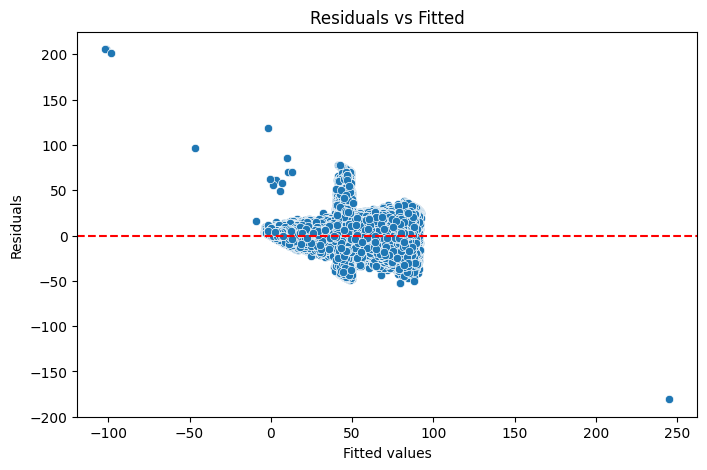

In [83]:
# The variance of residuals does not appear to be constant across all observations
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_val['preds'], y=df_val['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

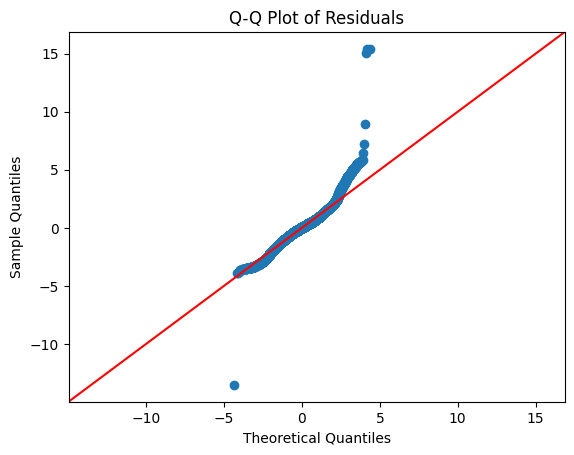

In [84]:
import statsmodels.api as sm

sm.qqplot(df_val['residuals'], line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

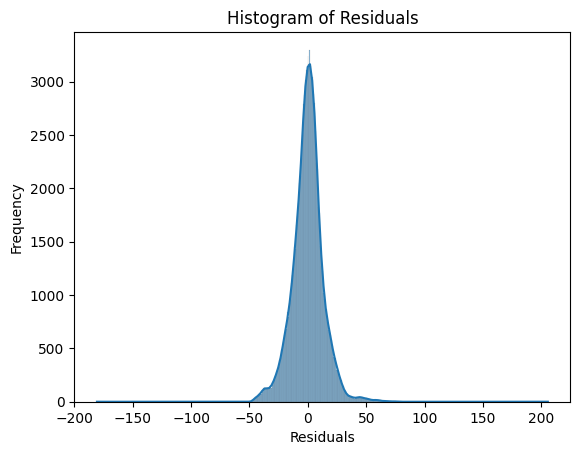

In [85]:
sns.histplot(df_val['residuals'], kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [74]:
# Retrain the model on the full training dataset
TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
train['Name_n'] = TE.fit_transform(train.Podcast_Name, train[Target])
test['Name_n'] = TE.transform(test.Podcast_Name)

TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
train['Genre_n'] = TE.fit_transform(train.Genre, train[Target])
test['Genre_n'] = TE.transform(test.Genre)


In [80]:
scaler = StandardScaler()
train[regression_vars] = scaler.fit_transform(train[regression_vars])
test[regression_vars] = scaler.transform(test[regression_vars])

lg = LinearRegression()
lg.fit(train[regression_vars], train[Target])

preds = lg.predict(train[regression_vars])
rmse = root_mean_squared_error(train[Target], preds)
print(f'Train RMSE: {rmse}')

orig_preds = lg.predict(orig[regression_vars])
rmse = root_mean_squared_error(orig[Target], orig_preds)
print(f'Original RMSE: {rmse}')

test_preds = lg.predict(test[regression_vars])
sub[Target] = test_preds
sub.to_csv('submission_baseline_v3.csv', index=False)

Train RMSE: 13.372305977444345
Original RMSE: 13.88736384941257
